### Импортирую библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

Pandas version: 2.2.0
Numpy version: 1.26.4


### Загрузим данные, посмотрим на их форму и значения

In [2]:
group1 = pd.read_csv("first_group_sku.csv")
print(group1.shape)
group1.head()

(245, 4)


,dates,SKU,price_per_sku,num_purchases
0,2018-04-20,32950,422.975,3
1,2018-04-24,32950,429.275,3
2,2018-04-27,32950,435.100,3
3,2018-04-30,32950,NaN,1
4,2018-05-03,32950,440.950,2


In [3]:
group2 = pd.read_csv("second_group_sku.csv")
print(group2.shape)
group2.head()

(3749, 4)


,dates,SKU,price_per_sku,num_purchases
0,2018-04-19,10334,92.890,10
1,2018-04-20,10334,92.890,11
2,2018-04-21,10334,92.890,10
3,2018-04-22,10334,92.890,12
4,2018-04-23,10334,92.456,10


In [4]:
group3 = pd.read_csv("third_group_sku.csv")
print(group3.shape)
group3.head()

(2781, 4)


,dates,SKU,price_per_sku,num_purchases
0,2018-04-22,11050,101.575,10
1,2018-04-23,11050,101.344,9
2,2018-04-25,11050,101.344,9
3,2018-04-26,11050,101.344,9
4,2018-04-27,11050,101.344,10


In [5]:
answer = pd.read_csv("answer.csv")
print(answer.shape)
answer.head()

(175, 3)


,dates,SKU,price_per_sku
0,2019-04-10,32950,450.200
1,2019-04-11,32950,449.925
2,2019-04-12,32950,447.575
3,2019-04-13,32950,448.400
4,2019-04-16,32950,446.525


### Видели что были NaN значения в первом файле, посмотри на них подробнее

In [6]:
group1.isna().sum()

dates             0
SKU               0
price_per_sku    76
num_purchases     0
dtype: int64

In [7]:
group1[group1.isna().any(axis=1)].SKU.value_counts(dropna=False)

SKU
32950    44
78833    32
Name: count, dtype: int64

In [8]:
group2.isna().sum()

dates            0
SKU              0
price_per_sku    0
num_purchases    0
dtype: int64

In [9]:
group3.isna().sum()

dates            0
SKU              0
price_per_sku    0
num_purchases    0
dtype: int64

### Заполним пропущенные значения предыдущим

In [10]:
group1.ffill(inplace=True)

### Объединим данные

In [11]:
groups = pd.concat([group1, group2, group3])
print(groups.shape)
groups.sort_values('dates')

(6775, 4)


,dates,SKU,price_per_sku,num_purchases
1048,2018-01-17,60870,109.182,7
1049,2018-01-18,60870,109.182,7
1050,2018-01-19,60870,109.182,8
1051,2018-01-21,60870,109.182,7
1052,2018-01-22,60870,109.315,8
...,...,...,...,...
1911,2019-12-23,80631,92.257,5
2350,2019-12-23,84395,140.815,10
1321,2019-12-23,38767,74.536,7
782,2019-12-24,49661,165.978,8


### Проверим тип данных в колонках

In [12]:
groups.dtypes

dates             object
SKU                int64
price_per_sku    float64
num_purchases      int64
dtype: object

### Преобразуем дату

In [13]:
groups['dates'] = groups['dates'].astype("datetime64[ns]")
groups.dtypes

dates            datetime64[ns]
SKU                       int64
price_per_sku           float64
num_purchases             int64
dtype: object

### Посмотрим на распределение даты

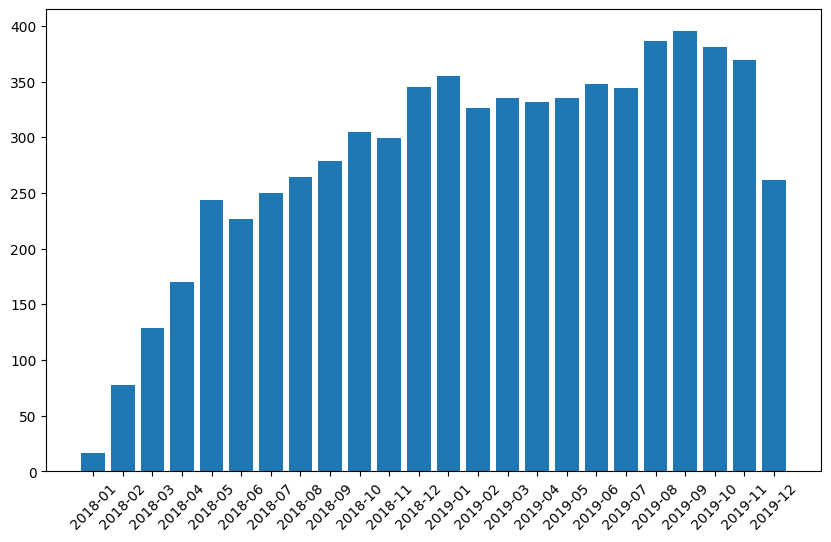

In [14]:
plt.figure(figsize=(10, 6))
date_counts = groups['dates'].dt.to_period('M').value_counts().sort_index()
plt.bar(date_counts.index.astype(str), date_counts.values)
plt.xticks(rotation=45)
plt.show()

### У нас большое количество записей на почти все месяцы, и имеет смысл достать из даты фичи

In [15]:
groups['year'] = groups['dates'].dt.year
groups['month'] = groups['dates'].dt.month
groups['week'] = groups['dates'].dt.isocalendar().week
groups['dow'] = groups['dates'].dt.dayofweek
groups.head()

,dates,SKU,price_per_sku,num_purchases,year,month,week,dow
0,2018-04-20,32950,422.975,3,2018,4,16,4
1,2018-04-24,32950,429.275,3,2018,4,17,1
2,2018-04-27,32950,435.100,3,2018,4,17,4
3,2018-04-30,32950,435.100,1,2018,4,18,0
4,2018-05-03,32950,440.950,2,2018,5,18,3


In [16]:
answer['dates'] = answer['dates'].astype("datetime64[ns]")
answer['year'] = answer['dates'].dt.year
answer['month'] = answer['dates'].dt.month
answer['week'] = answer['dates'].dt.isocalendar().week
answer['dow'] = answer['dates'].dt.dayofweek
answer.head()

,dates,SKU,price_per_sku,year,month,week,dow
0,2019-04-10,32950,450.200,2019,4,15,2
1,2019-04-11,32950,449.925,2019,4,15,3
2,2019-04-12,32950,447.575,2019,4,15,4
3,2019-04-13,32950,448.400,2019,4,15,5
4,2019-04-16,32950,446.525,2019,4,16,1


### Попробуем вначале предсказать с помощью обычной линейной регрессии. Также загрузим функции оценки r2 и rmse

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

### Так как SKU товара является по сути категорией, посмотрим на количество уникальных значений, и если оно не слишком велико, применим One-Hot Encoding

In [18]:
groups.SKU.nunique()

25

In [19]:
train = pd.get_dummies(groups, columns=['SKU'], drop_first=True)
test = pd.get_dummies(answer, columns=['SKU'], drop_first=True)
train.head()

,dates,price_per_sku,num_purchases,year,month,week,dow,SKU_11050,SKU_17812,SKU_19632,...,SKU_69997,SKU_72784,SKU_78833,SKU_80308,SKU_80631,SKU_83329,SKU_84395,SKU_89272,SKU_90611,SKU_98255
0,2018-04-20,422.975,3,2018,4,16,4,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2018-04-24,429.275,3,2018,4,17,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2018-04-27,435.100,3,2018,4,17,4,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2018-04-30,435.100,1,2018,4,18,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2018-05-03,440.950,2,2018,5,18,3,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
test.head()

,dates,price_per_sku,year,month,week,dow,SKU_11050,SKU_17812,SKU_19632,SKU_24125,...,SKU_69997,SKU_72784,SKU_78833,SKU_80308,SKU_80631,SKU_83329,SKU_84395,SKU_89272,SKU_90611,SKU_98255
0,2019-04-10,450.200,2019,4,15,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2019-04-11,449.925,2019,4,15,3,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2019-04-12,447.575,2019,4,15,4,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2019-04-13,448.400,2019,4,15,5,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2019-04-16,446.525,2019,4,16,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Обучим линейную регрессию. 2 модели по условию задачи, первая будет предсказывать количество покупок, а вторая - цену товара за единицу

In [21]:
model1 = LinearRegression()
model1.fit(train.drop(["dates", "price_per_sku", "num_purchases"], axis=1), train["num_purchases"])
cols_for_model1 = model1.feature_names_in_

model2 = LinearRegression()
model2.fit(train.drop(["dates", "price_per_sku"], axis=1), train["price_per_sku"])
cols_for_model2 = model2.feature_names_in_

In [22]:
# Посмотрим на влияние фичей на результат
pd.concat([pd.Series(model2.feature_names_in_, name="Feature name"), pd.Series(model2.coef_, name="Weight")], axis=1)

,Feature name,Weight
0,num_purchases,-1.253725
1,year,3.000021
2,month,0.246335
3,week,0.050151
4,dow,0.000521
5,SKU_11050,7.816897
6,SKU_17812,-30.856540
7,SKU_19632,53.634284
8,SKU_24125,9.343337
9,SKU_32950,348.858676


In [23]:
test["num_purchases"] = model1.predict(test[cols_for_model1]).round(0)
test["predicted_price"] = model2.predict(test[cols_for_model2]).round(3)
r2_score(test["price_per_sku"], test["predicted_price"])

0.9951124744604237

In [24]:
root_mean_squared_error(test["price_per_sku"], test["predicted_price"])

5.413471651796095

### Полученный результат подходит для решения задачи, однако посмотрим на результат других регрессионных моделей
### Посмотрим на случайный лес

In [25]:
from sklearn.ensemble import RandomForestRegressor

model1 = RandomForestRegressor(n_estimators=100, random_state=42)
model1.fit(train.drop(["dates", "price_per_sku", "num_purchases"], axis=1), train["num_purchases"])
cols_for_model1 = model1.feature_names_in_


model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(train.drop(["dates", "price_per_sku"], axis=1), train["price_per_sku"])
cols_for_model2 = model2.feature_names_in_

In [26]:
test["num_purchases"] = model1.predict(test[cols_for_model1]).round(0)
test["predicted_price"] = model2.predict(test[cols_for_model2]).round(3)
r2_score(test["price_per_sku"], test["predicted_price"])

0.9972663939396945

In [27]:
root_mean_squared_error(test["price_per_sku"], test["predicted_price"])

4.048548173527318

### Теперь проверим catboost

In [28]:
from catboost import CatBoostRegressor

model1 = CatBoostRegressor(iterations=1000, max_depth=8, loss_function='RMSE', random_state=42)
model1.fit(groups.drop(["dates", "price_per_sku", "num_purchases"], axis=1), 
           groups["num_purchases"], 
           cat_features=['SKU'], verbose=False)
cols_for_model1 = model1.feature_names_

model2 = CatBoostRegressor(iterations=1000, max_depth=8, loss_function='RMSE', random_state=42)
model2.fit(groups.drop(["dates", "price_per_sku"], axis=1), 
           groups["price_per_sku"], 
           cat_features=['SKU'], verbose=False)
cols_for_model2 = model2.feature_names_

In [29]:
answer["num_purchases"] = model1.predict(answer[cols_for_model1]).round(0)
answer["predicted_price"] = model2.predict(answer[cols_for_model2]).round(3)
r2_score(answer["price_per_sku"], answer["predicted_price"])

0.99681064149675

In [30]:
root_mean_squared_error(answer["price_per_sku"], answer["predicted_price"])

4.373035638180869

### Используем Decision Tree

In [31]:
from sklearn.tree import DecisionTreeRegressor

model1 = DecisionTreeRegressor(random_state=42)
model1.fit(train.drop(["dates", "price_per_sku", "num_purchases"], axis=1), train["num_purchases"])
cols_for_model1 = model1.feature_names_in_

model2 = DecisionTreeRegressor(random_state=42)
model2.fit(train.drop(["dates", "price_per_sku"], axis=1), train["price_per_sku"])
cols_for_model2 = model2.feature_names_in_

In [32]:
test["num_purchases"] = model1.predict(test[cols_for_model1]).round(0)
test["predicted_price"] = model2.predict(test[cols_for_model2]).round(3)
r2_score(test["price_per_sku"], test["predicted_price"])

0.9968709936273163

In [33]:
root_mean_squared_error(test["price_per_sku"], test["predicted_price"])

4.331462619775712

### Напоследок попробуем Deep Learning. Создадим простую нейросеть

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import Adam

print(f"torch version: {torch.__version__}")

torch version: 2.3.1+cu121


In [35]:
# Преобразуем данные в тензоры

# для начала создадим функцию, которая будет принимать датафрейм, приводить все значения в нем к одному типу (в данном случае можно привести к int32) и возращать нам
def process_df(temp_df: pd.DataFrame):
    bool_columns = temp_df.select_dtypes(include=['bool']).columns
    temp_df[bool_columns] = temp_df[bool_columns].astype(int)
    temp_df["week"] = temp_df["week"].astype(int)
    return temp_df

# обрабатываем train датасет для предсказания количества покупок
df = process_df(train.drop(["dates", "price_per_sku", "num_purchases"], axis=1))
# Теперь создаем из получившегося датафрейма тензор с фичами
X = torch.tensor(df.values, dtype=torch.float32)
y = torch.tensor(train["num_purchases"].values, dtype=torch.float32)
print(f"Количество фичей для датасета №1: {len(X[0])}")

# Создаем TensorDataset и DataLoader
train_dataset1 = TensorDataset(X, y)
train_loader1 = DataLoader(train_dataset1, batch_size=100, shuffle=True)

# теперь обработаем train датасет для предсказания цены, создадим также датасет и лоадер
# сначала получим список колонок и переместим num_purchases в конец (так как мы потом будем соединять получившееся предсказание от первой модели, и оно будет последней колонкой)
cols = train.drop(["dates", "price_per_sku"], axis=1).columns.tolist()
cols = cols[1:] + [cols[0]]
df = process_df(train[cols].copy())
X = torch.tensor(df.values, dtype=torch.float32)
y = torch.tensor(train["price_per_sku"].values, dtype=torch.float32)
print(f"Количество фичей для датасета №2: {len(X[0])}")
train_dataset2 = TensorDataset(X, y)
train_loader2 = DataLoader(train_dataset2, batch_size=100, shuffle=True)

# определим функцию для обучения модели
def train_model(model: nn.Module, optim: torch.optim.Optimizer, criterion: nn.Module, loader: DataLoader, num_epochs: int):
    for _ in range(num_epochs):
        for batch in loader:
            optim.zero_grad()
            X, y = batch
            outputs = model(X)
            loss = criterion(outputs.squeeze(1), y)
            loss.backward()
            optim.step()

Количество фичей для датасета №1: 28
Количество фичей для датасета №2: 29


In [38]:
class sku_model(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.pipeline = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pipeline(x)

# создаем модель 1 для предсказания количества покупок
model1 = sku_model(in_features=28)
optimizer = Adam(model1.parameters(), lr=0.02)
criterion = nn.MSELoss()
# тренируем модель 1
train_model(model1, optimizer, criterion, train_loader1, 60)
# создаем модель 2 для предсказания цены товара
model2 = sku_model(in_features=29)
optimizer = Adam(model2.parameters(), lr=0.02)
train_model(model2, optimizer, criterion, train_loader2, 60)

In [39]:
# перед преобразованием тестового датафрейма удалим старые предикты
test = test.drop(["num_purchases", "predicted_price"], axis=1)
# преобразовываем тестовый датафрейм
df = process_df(test.drop(["dates", "price_per_sku"], axis=1))
X = torch.tensor(df.values, dtype=torch.float32)
# предсказываем количество товара
with torch.no_grad():
    result_purchase = torch.round(model1(X))

# добавляет полученные предсказания количества товара к тестовым данным
X = torch.concat((X, result_purchase), dim=1)
# предсказываем стоимость товара
with torch.no_grad():
    result_price = torch.round(model2(X), decimals=3)

test["num_purchases"] = result_purchase.numpy()
test["predicted_price"] = result_price.numpy()

root_mean_squared_error(test["price_per_sku"], test["predicted_price"])

7.170344284781934

### Итог: задание решается разными видами регрессий даже без подбора параметров. Также задание можно решить через простую нейросеть, в которой однако необходимо подбирать параметры